In [1]:
import torch
import numpy as np
import imageio
import glob
from torch.utils.data import DataLoader, TensorDataset, Dataset
import matplotlib.pyplot as plt
import time
import torch.nn as nn
import torch
import torch.optim as optim

def load_mnist():
 
    NUM_LABELS = 10        
    test_images = []
    test_labels = []    
    
    for label in range(NUM_LABELS):
        for image_path in glob.glob("D:/Uppsala/Deep learning for Image Analysis/Assignment3/MNIST/Test/" + str(label) + "/*.png"):
            image = imageio.imread(image_path)
            test_images.append(image)
            letter = [0 for _ in range(0,NUM_LABELS)]    
            letter[label] = 1
            test_labels.append(letter)  
            
    train_images = []
    train_labels = []    
    
    for label in range(NUM_LABELS):
        for image_path in glob.glob("D:/Uppsala/Deep learning for Image Analysis/Assignment3/MNIST/Train/" + str(label) + "/*.png"):
            image = imageio.imread(image_path)
            train_images.append(image)
            letter = [0 for _ in range(0,NUM_LABELS)]    
            letter[label] = 1
            train_labels.append(letter)                  
            
    X_train= np.array(train_images).reshape(-1,784)/255.0
    Y_train= np.array(train_labels)
    X_test= np.array(test_images).reshape(-1,784)/255.0
    Y_test= np.array(test_labels)
    
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)
    
    return X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor


In [2]:
X_train, Y_train, X_test, Y_test = load_mnist()

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
print(device)

class MNISTDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

train_dataset = MNISTDataset(X_train, Y_train)
test_dataset = MNISTDataset(X_test, Y_test)

C:\Users\bidle\AppData\Local\Temp\ipykernel_20244\673405403.py:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)
C:\Users\bidle\AppData\Local\Temp\ipykernel_20244\673405403.py:31: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)


cpu


In [3]:
def train_and_evaluate(model, loss_function, optimizer, train_dataset, test_dataset, epochs, batch_size, learning_rate, device):
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    model = model.to(device)

    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            _, labels = torch.max(labels, 1)
            optimizer.zero_grad()
            images = images.view(batch_size, 1, 28, 28)
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += torch.eq(predicted, labels).sum().item()
        
        train_loss = running_loss / len(trainloader)
        train_losses.append(train_loss)
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                _, labels = torch.max(labels, 1)
                images = images.view(batch_size, 1, 28, 28)
                outputs = model(images)
                loss = loss_function(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += torch.eq(predicted, labels).sum().item()
        
        val_loss /= len(testloader)
        val_losses.append(val_loss)
        
        val_accuracy = 100 * correct_val / total_val
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'Training time: {elapsed_time:.2f} seconds')
    
    lg = 13
    md = 10
    sm = 9
    title = "Model Training and Evaluation"
    subtitle = f"| Batch size:{batch_size} | Learning rate:{learning_rate} | Number of Epochs:{epochs} | Training time:{elapsed_time:.2f} sec |"
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(title, fontsize=lg)
    fig.subplots_adjust(top=0.75)
    fig.text(0.5, 0.85, subtitle, ha='center', fontsize=md)
    x = range(1, len(train_losses) + 1)
    
    axs[0].plot(x, train_losses, label=f'Final train loss: {train_losses[-1]:.4f}')
    axs[0].plot(x, val_losses, label=f'Final validation loss: {val_losses[-1]:.4f}')
    axs[0].set_title('Losses', fontsize=md)
    axs[0].set_xlabel('Epoch', fontsize=md)
    axs[0].set_ylabel('Loss', fontsize=md)
    axs[0].legend(fontsize=sm)
    axs[0].tick_params(axis='both', labelsize=sm)
    axs[0].grid(True, which="both", linestyle='--', linewidth=0.5)
    
    axs[1].plot(x, train_accuracies, label=f'Final train accuracy: {train_accuracies[-1]:.4f}%')
    axs[1].plot(x, val_accuracies, label=f'Final validation accuracy: {val_accuracies[-1]:.4f}%')
    axs[1].set_title('Accuracy', fontsize=md)
    axs[1].set_xlabel('Epoch', fontsize=md)
    axs[1].set_ylabel('Accuracy (%)', fontsize=sm)
    axs[1].legend(fontsize=sm)
    axs[1].tick_params(axis='both', labelsize=sm)
    axs[1].grid(True, which="both", linestyle='--', linewidth=0.5)
    
    plt.show()

In [4]:
class FullyConnectedNetwork(nn.Module):
    def __init__(self, input_size, hidden_layer_sizes, classes):
        super(FullyConnectedNetwork, self).__init__()
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layer_sizes[0])])
        self.hidden_layers.extend([nn.Linear(hidden_layer_sizes[i], hidden_layer_sizes[i+1]) for i in range(len(hidden_layer_sizes)-1)])
        self.output_layer = nn.Linear(hidden_layer_sizes[-1], classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for layer in self.hidden_layers:
            x = self.relu(layer(x))
        x = self.output_layer(x)
        x = self.relu(x)
        x = self.softmax(x)
        return x



Epoch [1/10], Training Loss: 2.2970, Training Accuracy: 11.07%, Validation Loss: 2.2870, Validation Accuracy: 14.90%
Epoch [2/10], Training Loss: 2.2552, Training Accuracy: 21.53%, Validation Loss: 2.2027, Validation Accuracy: 28.35%
Epoch [3/10], Training Loss: 2.1360, Training Accuracy: 34.20%, Validation Loss: 2.0681, Validation Accuracy: 47.80%
Epoch [4/10], Training Loss: 2.0043, Training Accuracy: 52.69%, Validation Loss: 1.9604, Validation Accuracy: 53.70%
Epoch [5/10], Training Loss: 1.9465, Training Accuracy: 54.10%, Validation Loss: 1.9327, Validation Accuracy: 54.52%
Epoch [6/10], Training Loss: 1.9279, Training Accuracy: 54.60%, Validation Loss: 1.9202, Validation Accuracy: 54.94%
Epoch [7/10], Training Loss: 1.9177, Training Accuracy: 54.94%, Validation Loss: 1.9111, Validation Accuracy: 55.26%
Epoch [8/10], Training Loss: 1.8937, Training Accuracy: 59.11%, Validation Loss: 1.8702, Validation Accuracy: 62.64%
Epoch [9/10], Training Loss: 1.8661, Training Accuracy: 62.38%, 

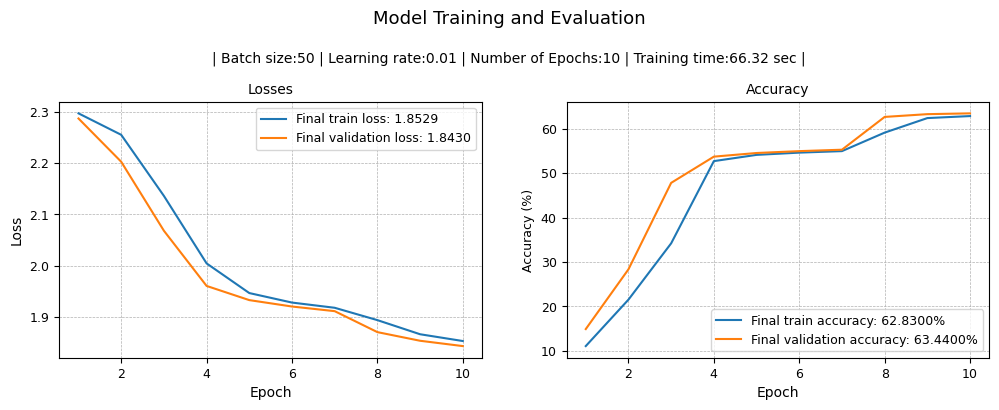

In [5]:
# FULLY CONNECTED NETWORK


epochs = 10
batch_size = 50
learning_rate = 0.01

hidden_layer_sizes = [100]
classes = 10

model = FullyConnectedNetwork(784, hidden_layer_sizes, classes).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_and_evaluate(model, loss_function, optimizer, train_dataset, test_dataset, epochs, batch_size, learning_rate, device)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.fc = nn.Linear(32 * 7 * 7, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.relu3(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.softmax(x)
        return x

Epoch [1/10], Training Loss: 1.8888, Training Accuracy: 58.28%, Validation Loss: 1.6134, Validation Accuracy: 85.10%
Epoch [2/10], Training Loss: 1.5701, Training Accuracy: 89.41%, Validation Loss: 1.5128, Validation Accuracy: 95.12%
Epoch [3/10], Training Loss: 1.5046, Training Accuracy: 95.87%, Validation Loss: 1.4980, Validation Accuracy: 96.53%
Epoch [4/10], Training Loss: 1.4947, Training Accuracy: 96.77%, Validation Loss: 1.4869, Validation Accuracy: 97.57%
Epoch [5/10], Training Loss: 1.4893, Training Accuracy: 97.32%, Validation Loss: 1.4840, Validation Accuracy: 97.74%
Epoch [6/10], Training Loss: 1.4855, Training Accuracy: 97.65%, Validation Loss: 1.4832, Validation Accuracy: 97.79%
Epoch [7/10], Training Loss: 1.4835, Training Accuracy: 97.86%, Validation Loss: 1.4836, Validation Accuracy: 97.80%
Epoch [8/10], Training Loss: 1.4813, Training Accuracy: 98.05%, Validation Loss: 1.4808, Validation Accuracy: 98.11%
Epoch [9/10], Training Loss: 1.4799, Training Accuracy: 98.19%, 

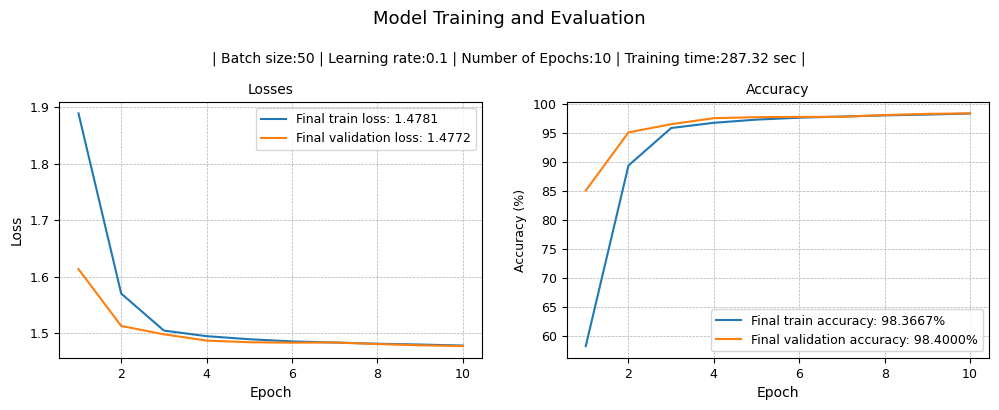

In [7]:
# CNN 1

epochs = 10
batch_size = 50
learning_rate = 0.1


model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_and_evaluate(model, loss_function, optimizer, train_dataset, test_dataset, epochs, batch_size, learning_rate, device)

In [8]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.fc = nn.Linear(32 * 7 * 7, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool1(self.conv1(x))
        x = self.relu1(x)
        x = self.pool2(self.conv2(x))
        x = self.relu2(x)
        x = self.relu3(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.softmax(x)
        return x

Epoch [1/10], Training Loss: 1.9102, Training Accuracy: 57.24%, Validation Loss: 1.6114, Validation Accuracy: 85.29%
Epoch [2/10], Training Loss: 1.6021, Training Accuracy: 86.12%, Validation Loss: 1.5891, Validation Accuracy: 87.51%
Epoch [3/10], Training Loss: 1.5855, Training Accuracy: 87.65%, Validation Loss: 1.5868, Validation Accuracy: 87.66%
Epoch [4/10], Training Loss: 1.5145, Training Accuracy: 94.86%, Validation Loss: 1.4908, Validation Accuracy: 97.24%
Epoch [5/10], Training Loss: 1.4913, Training Accuracy: 97.11%, Validation Loss: 1.4836, Validation Accuracy: 97.87%
Epoch [6/10], Training Loss: 1.4864, Training Accuracy: 97.56%, Validation Loss: 1.4853, Validation Accuracy: 97.67%
Epoch [7/10], Training Loss: 1.4838, Training Accuracy: 97.83%, Validation Loss: 1.4813, Validation Accuracy: 98.01%
Epoch [8/10], Training Loss: 1.4817, Training Accuracy: 98.01%, Validation Loss: 1.4899, Validation Accuracy: 97.24%
Epoch [9/10], Training Loss: 1.4804, Training Accuracy: 98.14%, 

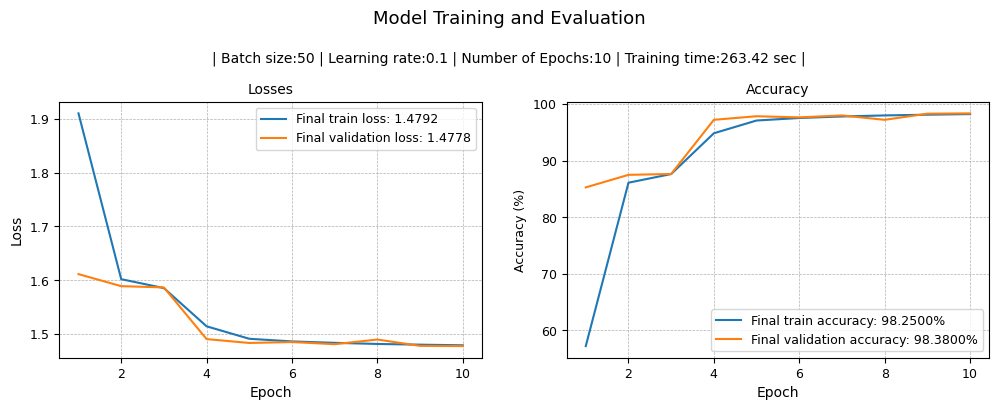

In [9]:
# CNN 2

epochs = 10
batch_size = 50
learning_rate = 0.1


model2 = CNN2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model2.parameters(), lr=learning_rate)

train_and_evaluate(model2, loss_function, optimizer, train_dataset, test_dataset, epochs, batch_size, learning_rate, device)

Epoch [1/10], Training Loss: 1.5686, Training Accuracy: 89.64%, Validation Loss: 1.4993, Validation Accuracy: 96.34%
Epoch [2/10], Training Loss: 1.4961, Training Accuracy: 96.62%, Validation Loss: 1.4934, Validation Accuracy: 96.89%
Epoch [3/10], Training Loss: 1.4876, Training Accuracy: 97.42%, Validation Loss: 1.4857, Validation Accuracy: 97.63%
Epoch [4/10], Training Loss: 1.4834, Training Accuracy: 97.84%, Validation Loss: 1.4798, Validation Accuracy: 98.23%
Epoch [5/10], Training Loss: 1.4792, Training Accuracy: 98.23%, Validation Loss: 1.4825, Validation Accuracy: 97.90%
Epoch [6/10], Training Loss: 1.4773, Training Accuracy: 98.41%, Validation Loss: 1.4784, Validation Accuracy: 98.29%
Epoch [7/10], Training Loss: 1.4756, Training Accuracy: 98.57%, Validation Loss: 1.4748, Validation Accuracy: 98.71%
Epoch [8/10], Training Loss: 1.4744, Training Accuracy: 98.68%, Validation Loss: 1.4771, Validation Accuracy: 98.45%
Epoch [9/10], Training Loss: 1.4742, Training Accuracy: 98.72%, 

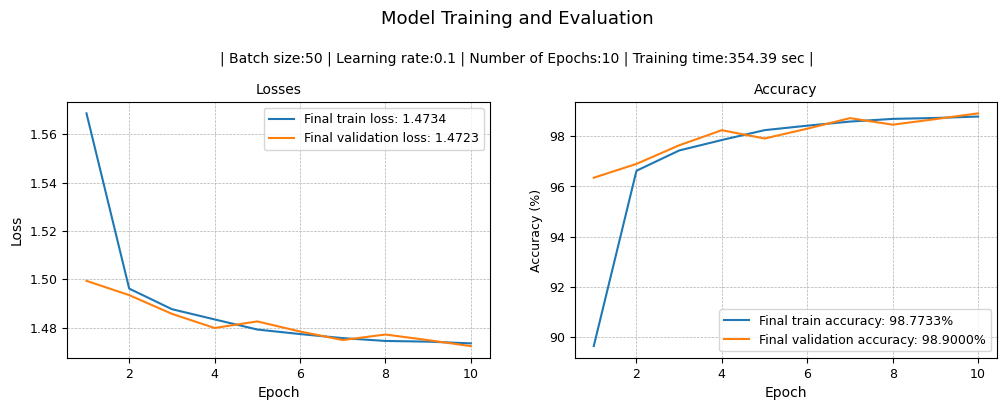

In [10]:
# CNN 3

epochs = 10
batch_size = 50
learning_rate = 0.1


model_adam = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_adam.parameters(), betas=(0.9, 0.999), eps=1e-8) 

train_and_evaluate(model_adam, loss_function, optimizer, train_dataset, test_dataset, epochs, batch_size, learning_rate, device)

In [11]:
class CNNVar1(nn.Module):
    def __init__(self):
        super(CNNVar1, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.25)
        self.fc = nn.Linear(32 * 7 * 7, 10)
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.dropout2(x)
        x = self.relu3(self.conv3(x))
        x = self.dropout3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.softmax(x)
        return x

class CNNVar2(nn.Module):
    def __init__(self):
        super(CNNVar2, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.sigmoid1 = nn.Sigmoid()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.sigmoid2 = nn.Sigmoid()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.sigmoid3 = nn.Sigmoid()
        self.fc = nn.Linear(32 * 7 * 7, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool1(self.sigmoid1(self.conv1(x)))
        x = self.pool2(self.sigmoid2(self.conv2(x)))
        x = self.sigmoid3(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.softmax(x)
        return x
    
class CNNVar3(nn.Module):
    def __init__(self):
        super(CNNVar3, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.ReLU(32)
        self.relu3 = nn.ReLU()
        self.fc = nn.Linear(32 * 7 * 7, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.relu3(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.softmax(x)
        return x
    


Epoch [1/10], Training Loss: 1.9878, Training Accuracy: 46.25%, Validation Loss: 1.6301, Validation Accuracy: 83.50%
Epoch [2/10], Training Loss: 1.6510, Training Accuracy: 81.37%, Validation Loss: 1.5948, Validation Accuracy: 86.89%
Epoch [3/10], Training Loss: 1.6171, Training Accuracy: 84.61%, Validation Loss: 1.5851, Validation Accuracy: 87.70%
Epoch [4/10], Training Loss: 1.6064, Training Accuracy: 85.61%, Validation Loss: 1.5785, Validation Accuracy: 88.35%
Epoch [5/10], Training Loss: 1.5998, Training Accuracy: 86.22%, Validation Loss: 1.5754, Validation Accuracy: 88.63%
Epoch [6/10], Training Loss: 1.5947, Training Accuracy: 86.74%, Validation Loss: 1.5735, Validation Accuracy: 88.85%
Epoch [7/10], Training Loss: 1.5912, Training Accuracy: 87.08%, Validation Loss: 1.5716, Validation Accuracy: 88.97%
Epoch [8/10], Training Loss: 1.5891, Training Accuracy: 87.29%, Validation Loss: 1.5704, Validation Accuracy: 89.11%
Epoch [9/10], Training Loss: 1.5868, Training Accuracy: 87.48%, 

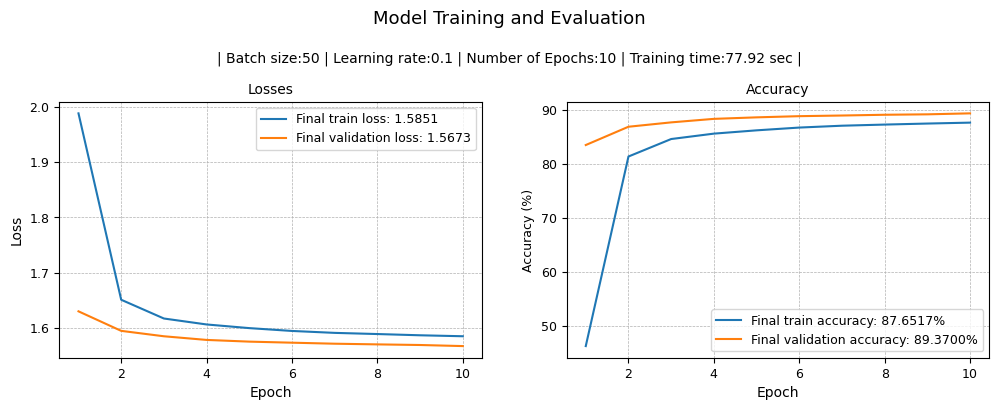

Epoch [1/30], Training Loss: 2.3030, Training Accuracy: 10.63%, Validation Loss: 2.3019, Validation Accuracy: 11.35%
Epoch [2/30], Training Loss: 2.3029, Training Accuracy: 10.51%, Validation Loss: 2.3021, Validation Accuracy: 10.28%
Epoch [3/30], Training Loss: 2.3023, Training Accuracy: 10.72%, Validation Loss: 2.3012, Validation Accuracy: 11.35%
Epoch [4/30], Training Loss: 2.3020, Training Accuracy: 10.94%, Validation Loss: 2.3012, Validation Accuracy: 11.35%
Epoch [5/30], Training Loss: 2.3018, Training Accuracy: 10.85%, Validation Loss: 2.3012, Validation Accuracy: 11.35%
Epoch [6/30], Training Loss: 2.3014, Training Accuracy: 11.16%, Validation Loss: 2.3009, Validation Accuracy: 10.28%
Epoch [7/30], Training Loss: 2.3011, Training Accuracy: 11.21%, Validation Loss: 2.3007, Validation Accuracy: 13.51%
Epoch [8/30], Training Loss: 2.3004, Training Accuracy: 11.35%, Validation Loss: 2.2992, Validation Accuracy: 11.35%
Epoch [9/30], Training Loss: 2.2989, Training Accuracy: 11.46%, 

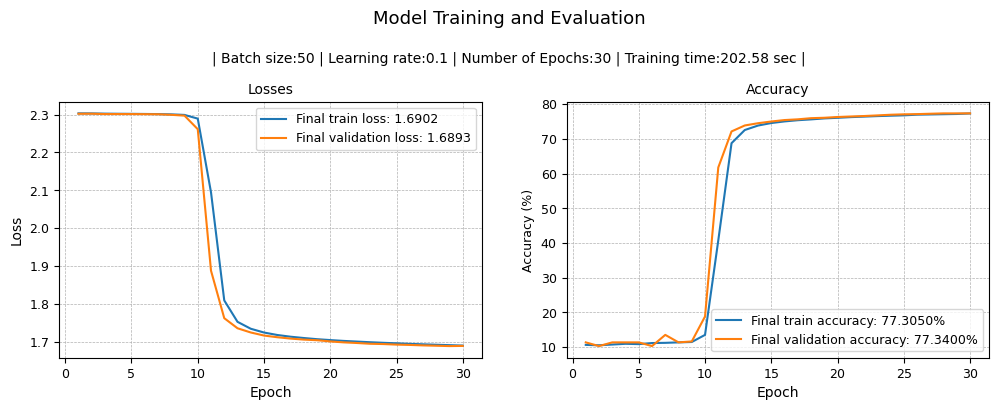

Epoch [1/10], Training Loss: 1.5521, Training Accuracy: 91.85%, Validation Loss: 1.4911, Validation Accuracy: 97.38%
Epoch [2/10], Training Loss: 1.4887, Training Accuracy: 97.49%, Validation Loss: 1.4827, Validation Accuracy: 98.10%
Epoch [3/10], Training Loss: 1.4826, Training Accuracy: 98.06%, Validation Loss: 1.4830, Validation Accuracy: 98.00%
Epoch [4/10], Training Loss: 1.4794, Training Accuracy: 98.32%, Validation Loss: 1.4782, Validation Accuracy: 98.45%
Epoch [5/10], Training Loss: 1.4769, Training Accuracy: 98.57%, Validation Loss: 1.4775, Validation Accuracy: 98.53%
Epoch [6/10], Training Loss: 1.4750, Training Accuracy: 98.76%, Validation Loss: 1.4764, Validation Accuracy: 98.61%
Epoch [7/10], Training Loss: 1.4733, Training Accuracy: 98.92%, Validation Loss: 1.4733, Validation Accuracy: 98.89%
Epoch [8/10], Training Loss: 1.4724, Training Accuracy: 98.98%, Validation Loss: 1.4747, Validation Accuracy: 98.79%
Epoch [9/10], Training Loss: 1.4713, Training Accuracy: 99.11%, 

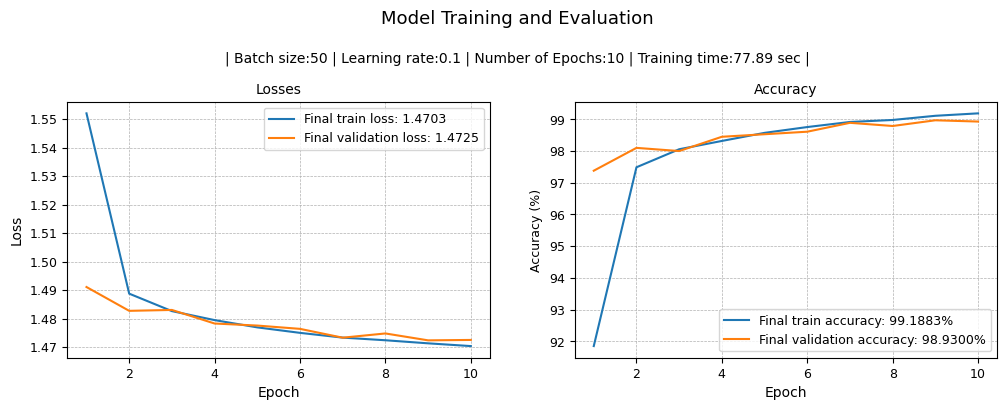

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


epochs = 10
batch_size = 50
learning_rate = 0.1


var1 = CNNVar1().to(device)
var2 = CNNVar2().to(device)
var3 = CNNVar3().to(device)
criterion = nn.CrossEntropyLoss()
optimizer1 = optim.SGD(var1.parameters(), lr=learning_rate)
optimizer2 = optim.SGD(var2.parameters(), lr=learning_rate)
optimizer3 = optim.SGD(var3.parameters(), lr=learning_rate)

train_and_evaluate(var1, loss_function, optimizer1, train_dataset, test_dataset, epochs, batch_size, learning_rate, device)
train_and_evaluate(var2, loss_function, optimizer2, train_dataset, test_dataset, 30, batch_size, 0.1, device)
train_and_evaluate(var3, loss_function, optimizer3, train_dataset, test_dataset, epochs, batch_size, learning_rate, device)



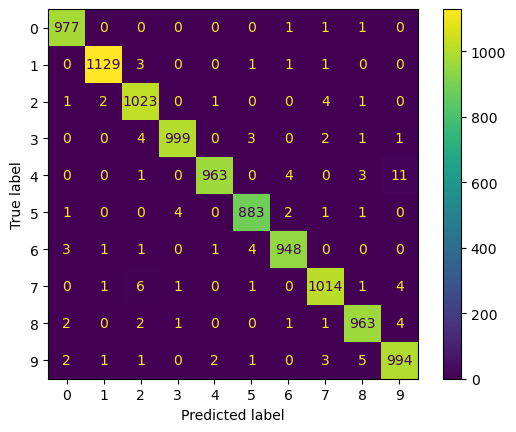

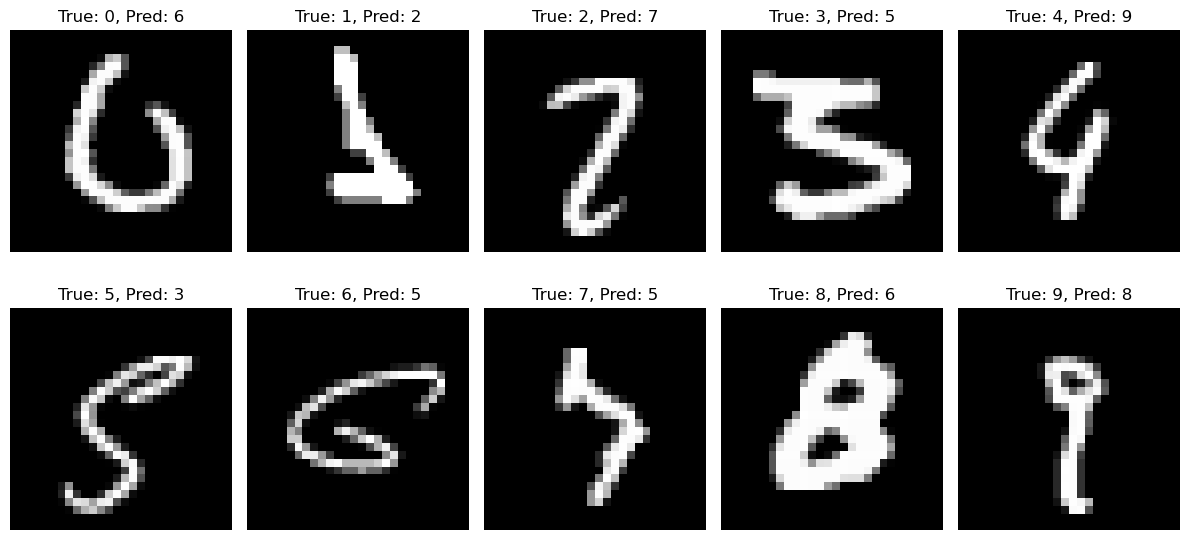

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

var3.eval()

X_test_imges = X_test.view(-1, 1, 28, 28).to(device)

with torch.no_grad():
    outputs = var3(X_test_imges)
    _, predicted = torch.max(outputs, 1)
    predicted = predicted.cpu().numpy()
    true_labels = np.argmax(Y_test.numpy(), axis=1)

cm = confusion_matrix(true_labels, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

misclassified_indices = np.where(predicted != true_labels)[0]

misclassified_images = []
misclassified_labels = []
misclassified_preds = []

for i in range(10):
    class_indices = np.where(true_labels[misclassified_indices] == i)[0]
    if len(class_indices) > 0:
        idx = misclassified_indices[class_indices[0]]
        misclassified_images.append(X_test[idx].reshape(28, 28))
        misclassified_labels.append(true_labels[idx])
        misclassified_preds.append(predicted[idx])

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()
for img, ax, true_label, pred_label in zip(misclassified_images, axes, misclassified_labels, misclassified_preds):
    ax.imshow(img, cmap='gray')
    ax.set_title(f'True: {true_label}, Pred: {pred_label}')
    ax.axis('off')
plt.tight_layout()
plt.show()

Epoch [1/30], Training Loss: 0.7307, Training Dice Score: 0.6480, Test Loss: 0.7318, Test Dice Score: 0.6421
Epoch [2/30], Training Loss: 0.7282, Training Dice Score: 0.6522, Test Loss: 0.7316, Test Dice Score: 0.6421
Epoch [3/30], Training Loss: 0.7270, Training Dice Score: 0.6538, Test Loss: 0.7313, Test Dice Score: 0.6421
Epoch [4/30], Training Loss: 0.7271, Training Dice Score: 0.6531, Test Loss: 0.7309, Test Dice Score: 0.6421
Epoch [5/30], Training Loss: 0.7242, Training Dice Score: 0.6570, Test Loss: 0.7303, Test Dice Score: 0.6421
Epoch [6/30], Training Loss: 0.7244, Training Dice Score: 0.6558, Test Loss: 0.7294, Test Dice Score: 0.6421
Epoch [7/30], Training Loss: 0.7256, Training Dice Score: 0.6523, Test Loss: 0.7277, Test Dice Score: 0.6421
Epoch [8/30], Training Loss: 0.7259, Training Dice Score: 0.6480, Test Loss: 0.7247, Test Dice Score: 0.6421
Epoch [9/30], Training Loss: 0.7252, Training Dice Score: 0.6430, Test Loss: 0.7201, Test Dice Score: 0.6421
Epoch [10/30], Trai

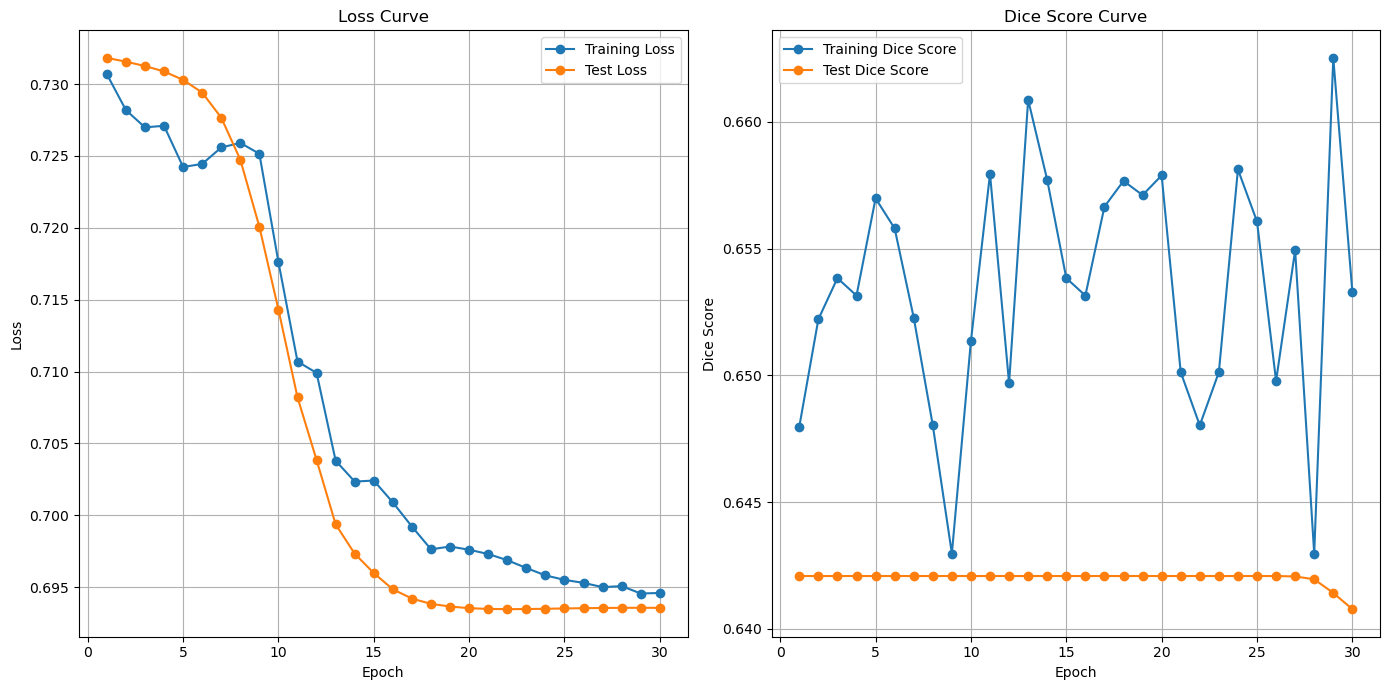

In [15]:
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import imageio
import glob
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

# Define the modified CNN architecture for segmentation
class SegmentationCNN(nn.Module):
    def __init__(self):
        super(SegmentationCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        
        self.sigmoid = nn.Sigmoid()

        
        self.upconv1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2)
        self.last_conv = nn.Conv2d(8, 3, kernel_size=1)
    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.relu3(self.conv3(x))
        x = self.upconv1(x)
        x = self.upconv2(x)
        x = self.last_conv(x)
        x = self.sigmoid(x)
        return x

loss_function = nn.BCEWithLogitsLoss()

class GlandDataset(Dataset):
    def __init__(self, image_paths, label_paths):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.to_tensor = ToTensor()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = Image.open(self.label_paths[idx]).convert('RGB')
        image = self.to_tensor(image)
        label = self.to_tensor(label)
        return image, label

def load_gland_data():
    train_images = glob.glob("WARWICK/Train/image_*.png")
    train_labels = glob.glob("WARWICK/Train/label_*.png")
    test_images = glob.glob("WARWICK/Test/image_*.png")
    test_labels = glob.glob("WARWICK/Test/label_*.png")
    return train_images, train_labels, test_images, test_labels

train_images, train_labels, test_images, test_labels = load_gland_data()

train_dataset = GlandDataset(train_images, train_labels)
test_dataset = GlandDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Initialize model, optimizer
model = SegmentationCNN()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

def dice_score(preds, labels, smooth=1e-6):
    preds = preds.contiguous()
    labels = labels.contiguous()
    
    intersection = (preds * labels).sum(dim=2).sum(dim=2)
    dice = (2. * intersection + smooth) / (preds.sum(dim=2).sum(dim=2) + labels.sum(dim=2).sum(dim=2) + smooth)
    
    return dice.mean().item()

def train_model(model, train_loader, test_loader, loss_function, optimizer, epochs):
    model.train()
    train_losses = []
    test_losses = []
    train_dice_scores = []
    test_dice_scores = []
    
    for epoch in range(epochs):
        running_train_loss = 0.0
        running_test_loss = 0.0
        train_dice = 0.0
        test_dice = 0.0
        
        # Training phase
        model.train()
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images.float()) 
            loss = loss_function(outputs, labels.float()) 
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            
            preds = torch.sigmoid(outputs) > 0.5
            train_dice += dice_score(preds, labels)
        
        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        train_dice_score = train_dice / len(train_loader)
        train_dice_scores.append(train_dice_score)
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images.float())
                loss = loss_function(outputs, labels.float())
                running_test_loss += loss.item()
                
                preds = torch.sigmoid(outputs) > 0.5
                test_dice += dice_score(preds, labels)
        
        epoch_test_loss = running_test_loss / len(test_loader)
        test_losses.append(epoch_test_loss)
        test_dice_score = test_dice / len(test_loader)
        test_dice_scores.append(test_dice_score)
        
        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {epoch_train_loss:.4f}, Training Dice Score: {train_dice_score:.4f}, Test Loss: {epoch_test_loss:.4f}, Test Dice Score: {test_dice_score:.4f}')
    
    # Plot the learning curves
    epochs_range = range(1, epochs + 1)
    
    plt.figure(figsize=(14, 7))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, marker='o', label='Training Loss')
    plt.plot(epochs_range, test_losses, marker='o', label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)
    
    # Plot Dice scores
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_dice_scores, marker='o', label='Training Dice Score')
    plt.plot(epochs_range, test_dice_scores, marker='o', label='Test Dice Score')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Score')
    plt.title('Dice Score Curve')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

train_model(model, train_loader, test_loader, loss_function, optimizer, epochs=30)
# first_image, first_label = train_dataset[0]
# print("First image tensor:", first_image)
# print("First label tensor:", first_label)

# first_image_np = first_image.numpy().transpose((1, 2, 0))
# first_label_np = first_label.numpy().squeeze().transpose((1, 2, 0))
# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# ax[0].imshow(first_image_np)
# ax[0].set_title('First Image')
# ax[1].imshow(first_label_np, cmap='gray')
# ax[1].set_title('First Label')
# plt.show()